### Введение в обработку естественного языка. Урок 4. Анализ тональности текста.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.figsize': (12,6)})
matplotlib.rcParams["axes.grid"] = True

In [3]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32921 sha256=e8de5d5054978f297de843919445df67c9297174ac0623c38342d7688b3a140a
  Stored in directory: c:\users\samia\appdata\local\pip\cache\wheels\fb\86\b2\277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [4]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from string import punctuation
import re
from tqdm.notebook import tqdm

In [5]:
# Загрузка данных
data = pd.read_excel("отзывы за лето.xls")
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [6]:
rating = data['Rating'].value_counts()
rating

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

<BarContainer object of 5 artists>

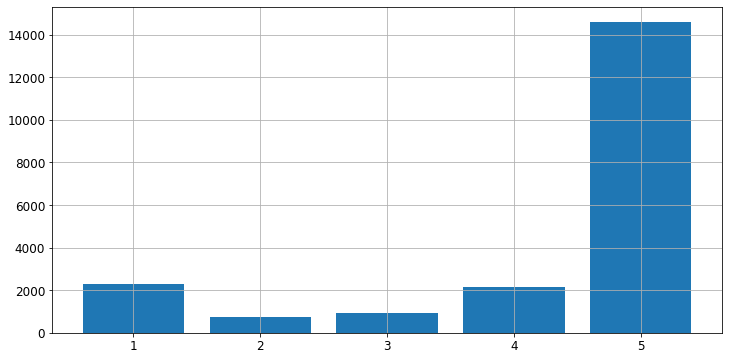

In [7]:
plt.bar(rating.index,rating)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


In [9]:
data.loc[data['Rating'] == 3, 'Content'].sample(10, random_state=42)

16552                 Ника не могу перевести деньги в Крым
17847    Приложение удобное, но часто вылетает после вв...
12852    Смущает простота входа в приложение. Вводится ...
8722               Пропала вторая карта после перезапуска.
8599     Запуск приложения со всеми проверкам три минут...
19408    Исправьте пожалуйста приложение. После последн...
7652                Нет доступа оплаты к некоторым услугам
15617    Перестал работать чат с банком. Пропала вся пе...
5871     Все было бы неплохо, но...при входе в приложен...
728      Постоянный глюк! При входе в приложение приход...
Name: Content, dtype: object

In [10]:
def targ(x):
    r = 0
    if x > 3:
        r = 1
    return r

In [11]:
data['target'] = data['Rating'].apply(lambda x:  targ(x))

In [13]:
data.tail()

,Rating,Content,Date,target
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01,0
20655,5,Ок,2017-06-01,1
20656,4,Доволен,2017-06-01,1
20657,1,"Песопаснасть, рут ни нужын",2017-06-01,0
20658,5,Сбербанк бомбовая компания на сегодняшний день...,2017-06-01,1


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['Content'], data['target'], test_size=0.2,
                                                    random_state=42, stratify=data['target'])

In [19]:
stop_w = set(get_stop_words("ru"))
punct  = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(text):
    txt = str(text)
    txt = "".join(c for c in txt if c not in punct)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in stop_w]
    return " ".join(txt)

X_train = X_train.apply(preprocess_text)
X_test  = X_test.apply(preprocess_text)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=5000)

In [23]:
X_train_v = vectorizer.fit_transform(X_train)
X_test_v  = vectorizer.transform(X_test)

In [25]:
%%time
model_log = LogisticRegressionCV(cv=3, penalty='l1', scoring='f1', solver='liblinear', 
                           class_weight='balanced', n_jobs=-1, random_state = 42)
model_log.fit(X_train_v, y_train)

Wall time: 1.49 s


LogisticRegressionCV(class_weight='balanced', cv=3, n_jobs=-1, penalty='l1',
                     random_state=42, scoring='f1', solver='liblinear')

In [26]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.8, 15):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

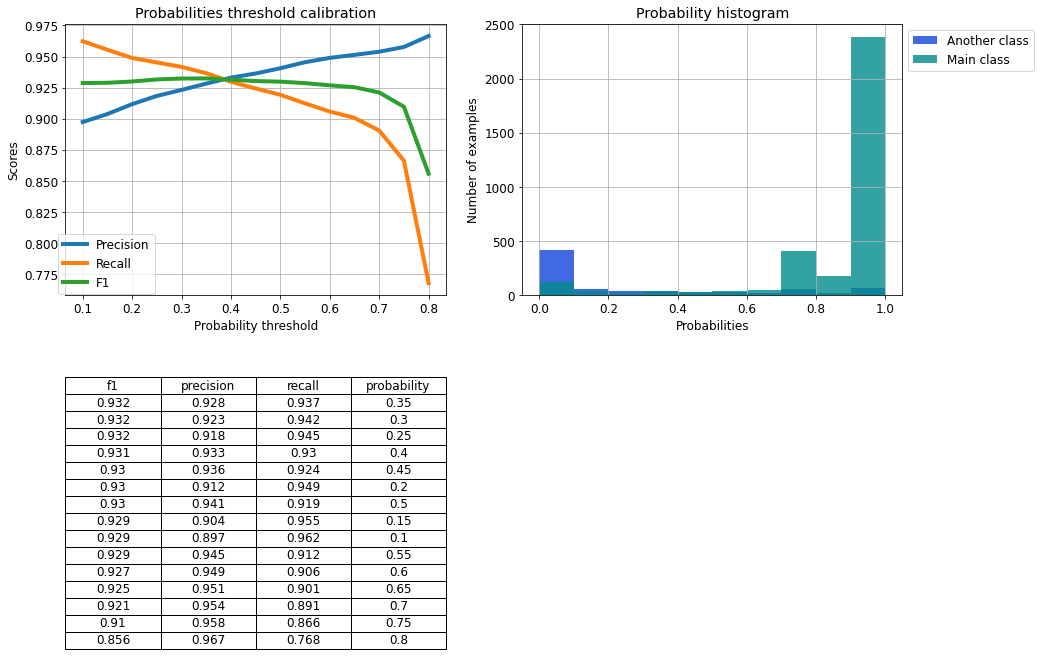

In [27]:
probs = model_log.predict_proba(X_test_v)
show_proba_calibration_plots(probs[:, 1], y_test.values)

In [31]:
def calc_pred(x):
    return np.array([1 if x >= 0.38 else 0 for x in x])

In [32]:
y_pred = calc_pred(probs[:, 1])

In [33]:
f1_score(y_test, y_pred)

0.9321983273596176